In [1]:
import pickle
import pandas as pd
from collections import Counter

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

note: I combined the first two runs with the other 10 runs

# Results 

In [127]:

from os.path import basename, normpath

for folder in glob("../results/*/"):  # get a list of all sub directories
    with open(folder+'regulons.pkl', 'rb') as f: 
        regulon = pickle.load(f)
    # run = basename(normpath(folder))
    # print(run)
        # get regulon results from pkl file to df and save as csv - for readability
        reg_df = pd.DataFrame({
            'TF': [reg.transcription_factor for reg in regulon],
            'genes': [list(reg.genes) for reg in regulon],
            'score': [reg.score for reg in regulon]
        })
        reg_df['size'] = reg_df['genes'].apply(lambda x: len(x))
        reg_df = reg_df.set_index('TF')
        # reg_df.to_csv(folder + 'regulons.csv')

First, make a list of all TFs and their frequency in the results

In [2]:
tfs_counter = Counter()
for folder in glob('../results/*/'):
    regulons_df = pd.read_csv(folder+'regulons.csv', index_col=0)
    tfs_counter.update(regulons_df.index)  # count appearance on TFs between different runs (overall 12 runs)
    


### Counts per TF

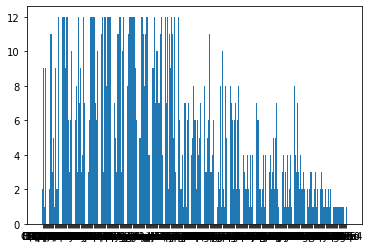

In [3]:
plt.bar(tfs_counter.keys(), tfs_counter.values())
plt.show()


### Frequency of TFs counts
Count how many TFs repeat in 1, 2, ...., 12 of the runs. 

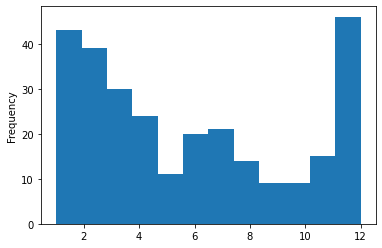

In [4]:
tfs_freq = pd.Series(tfs_counter)
tfs_freq = tfs_freq.sort_values(ascending=False)
ax = tfs_freq.plot.hist(bins=12)

show distribution with a boxplot

/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


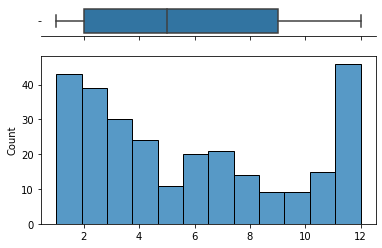

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(tfs_freq, ax=ax_box)
sns.histplot(tfs_freq, ax=ax_hist, bins=12)
sns.despine(ax=ax_box, left=True)
plt.axvline(9.25, color='red')

Produce list of TFs that appear in >80% of the runs

In [7]:
tfs_80 = tfs_freq[tfs_freq > 9]
# len(tfs_80) # 70  => 70 TFs that appear in over 80% (9) of the runs 
# len(tfs_freq)  # 281 
# ~ 26% of regulons


70

## How do genes differ between runs in the same TF regulon? Which genes to choose?

save for each run a regulon sub-matrix with only the 72 TFs that appear in more than 80% of the runs (>9 times).

Note: can do the same for the regulons.pkl, to later use the Regulon methods (i.e intersection..)

In [8]:

for folder in glob('../results/*/'):
    regulons_df = pd.read_csv(folder+'regulons.csv', index_col=0)
    regulons_top_freq = regulons_df.loc[[tf for tf in regulons_df.index if tf in tfs_80.index]]  # save regulons of the best confidence TFs (>80%)
    regulons_top_freq.to_csv(folder + 'regulons_top80.csv')

Count genes frequencies, for the same TF

In [10]:
from ast import literal_eval
import os 

all_dfs = pd.concat([pd.read_csv(folder + 'regulons_top80.csv', index_col=0) for folder in glob("../results/*/")])
all_dfs_genes = all_dfs['genes']  # keep only genes column, discard size of regulon and score
all_dfs_genes = all_dfs_genes.apply(literal_eval) # convert string to list
all_dfs_genes = all_dfs_genes.explode()
all_dfs_genes = pd.DataFrame(all_dfs_genes).rename({'genes': 'gene'}, axis='columns')
gene_counts = all_dfs_genes.groupby(['TF', 'gene']).size().to_frame('count')
gene_counts.to_csv("../results/gene_counts.csv")

gene_counts = gene_counts.reset_index()
gene_counts


TF     gene  count
0     CG5245     BuGZ      1
1     CG5245  CDK2AP1      2
2     CG5245  CG11409      1
3     CG5245  CG13920      1
4     CG5245  CG15382      2
...      ...      ...    ...
7043     zld      vnd      1
7044     zld      wdb      1
7045     zld     wech      4
7046     zld      zip      1
7047     zld      zld     12

[7048 rows x 3 columns]

### Is there a correlation between regulon size (|gene|) and it's score?

We'll look at one run as an example

In [118]:
run1_regulons = pd.read_csv('../results/run_01/regulons.csv', index_col=0)

genes     score  size
TF                                                                        
B-H2     ['capu', 'CG7724', 'CG18507', 'B-H2', 'CG9628'...  3.835759    10
BtbVII                                    ['Usp2', 'wech']  3.612887     2
CG11586                                  ['Ppt1', 'thoc6']  2.820949     2
CG17440  ['CG1324', 'Obp56h', 'CG32982', 'CG34170', 'Cd...  0.983616     5
CG17829  ['Orc4', 'lig', 'tam', 'Fit1', 'MED8', 'Spec2'...  1.424293    17
...                                                    ...       ...   ...
twi      ['retn', 'stumps', 'BobA', 'tin', 'Tom', 'pico...  4.319942    22
unc-4    ['Atf3', 'Lim1', 'Hr4', 'unc-4', 'fne', 'hig',...  0.238009     7
usp      ['CG8078', 'CG3909', 'CG10139', 'Vps13', 'usp'...  1.749538    25
wor      ['sna', 'spdo', 'Diap1', 'sca', 'Traf4', 'scrt...  0.922127    76
zld      ['Tollo', 'RhoGAP71E', 'msi', 'HipHop', 'haf',...  5.501028    92

[131 rows x 3 columns]

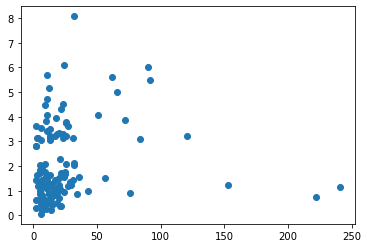

In [121]:
sizes = run1_regulons['size']
scores = run1_regulons['score']
ind = np.argsort(sizes)
plt.clf()
plt.scatter(sizes[ind], scores[ind])
plt.show()

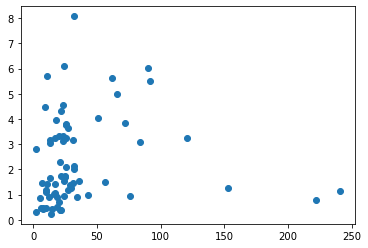

In [130]:
run2_regulons_80 = pd.read_csv('../results/run_02/regulons_top80.csv', index_col=0)
sizes = run2_regulons_80['size']
scores = run2_regulons_80['score']
ind = np.argsort(sizes)
plt.clf()
plt.scatter(sizes[ind], scores[ind])
plt.show()

### Heatmaps for top TFs per run

+ CHECK ON/OFF ON SPECIFIC GENES AND TFS!

upload cell types annotation per cell 

In [11]:
types_df = pd.read_csv("../data/cell_type.csv", index_col=0) 

/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: User

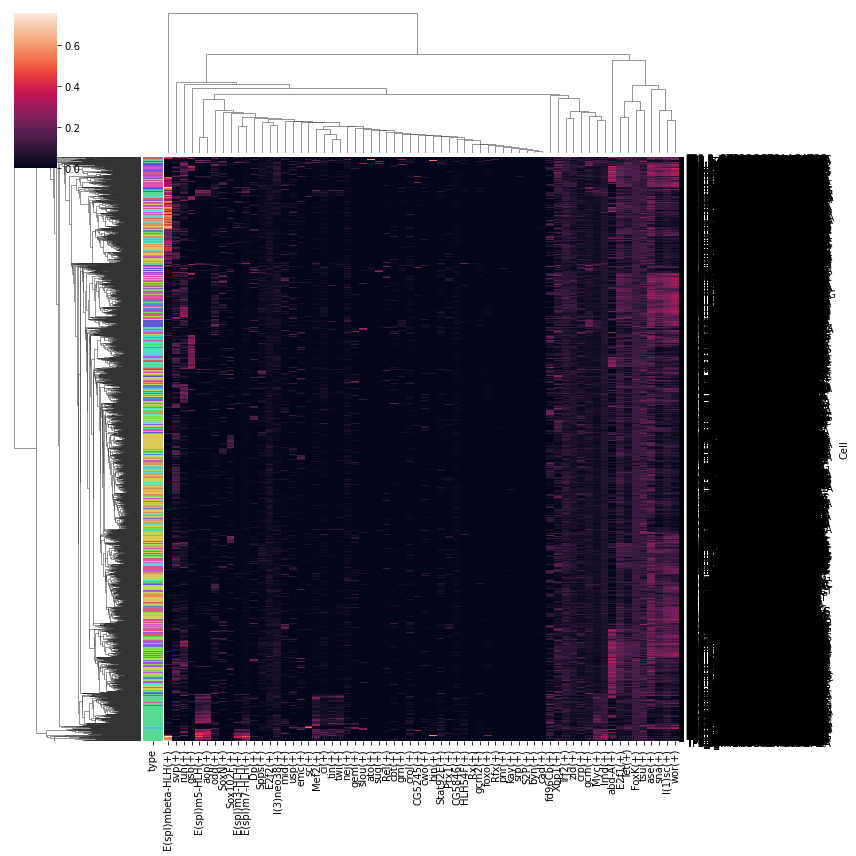

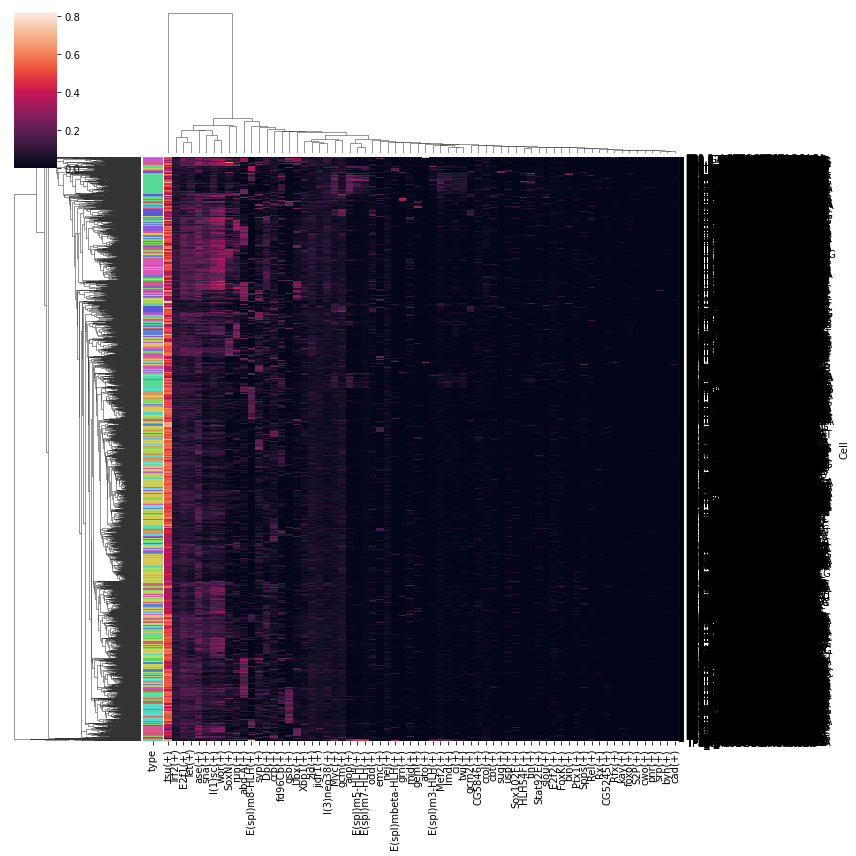

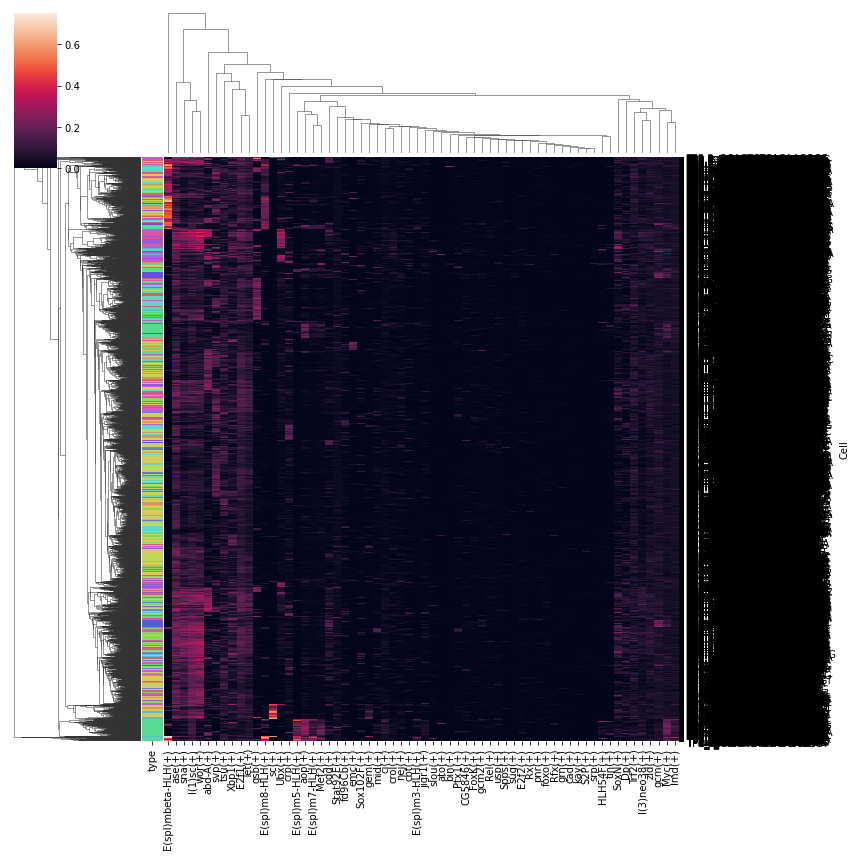

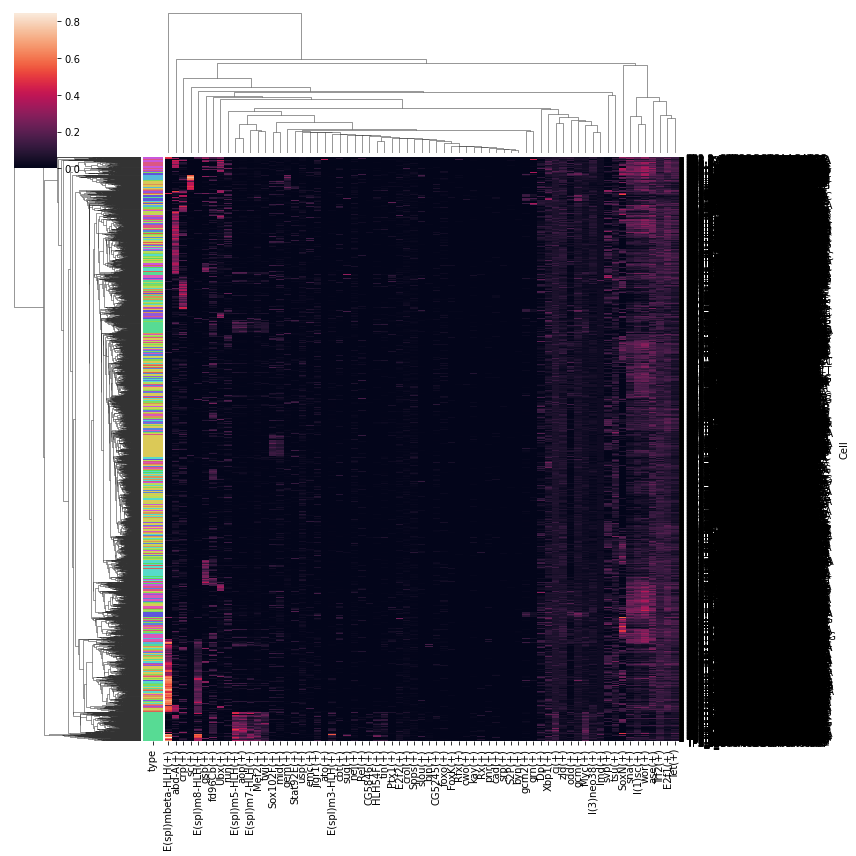

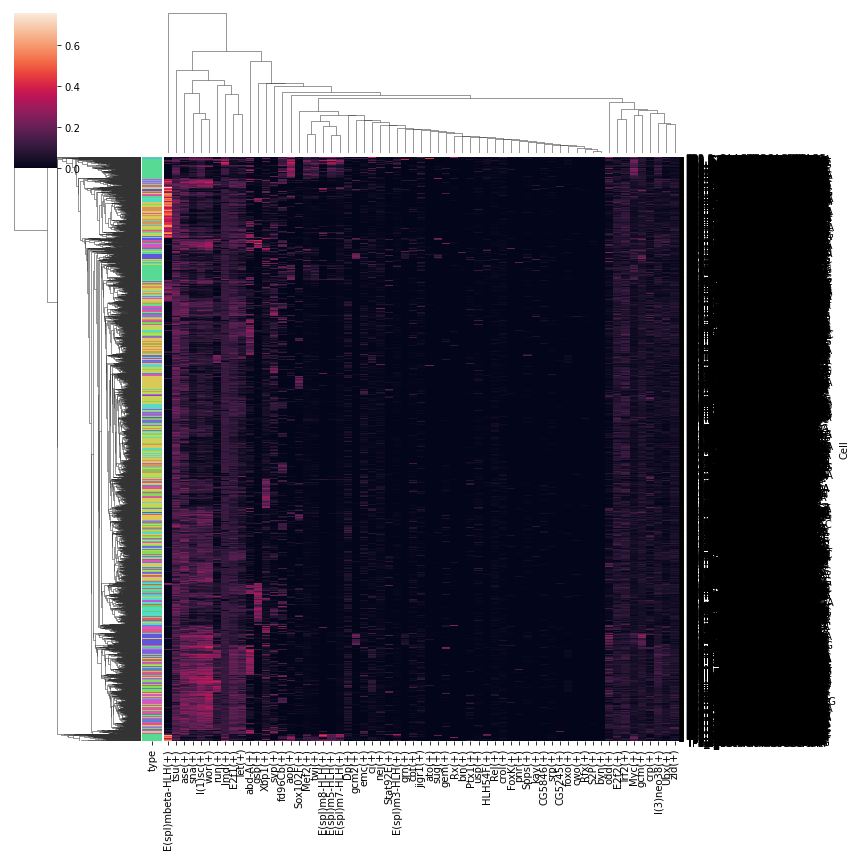

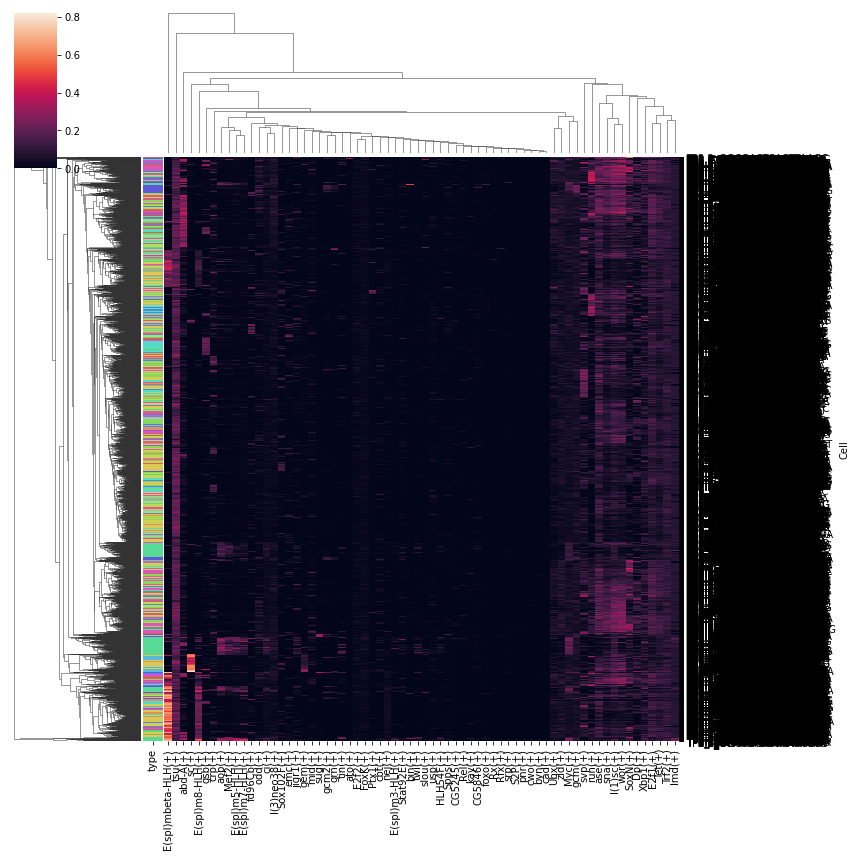

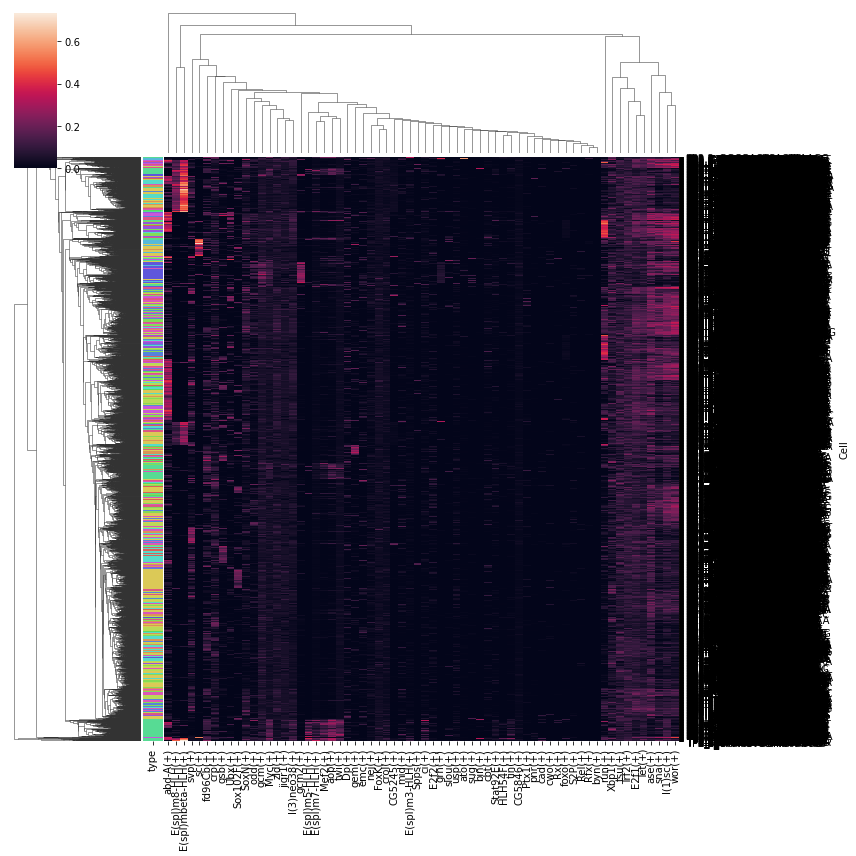

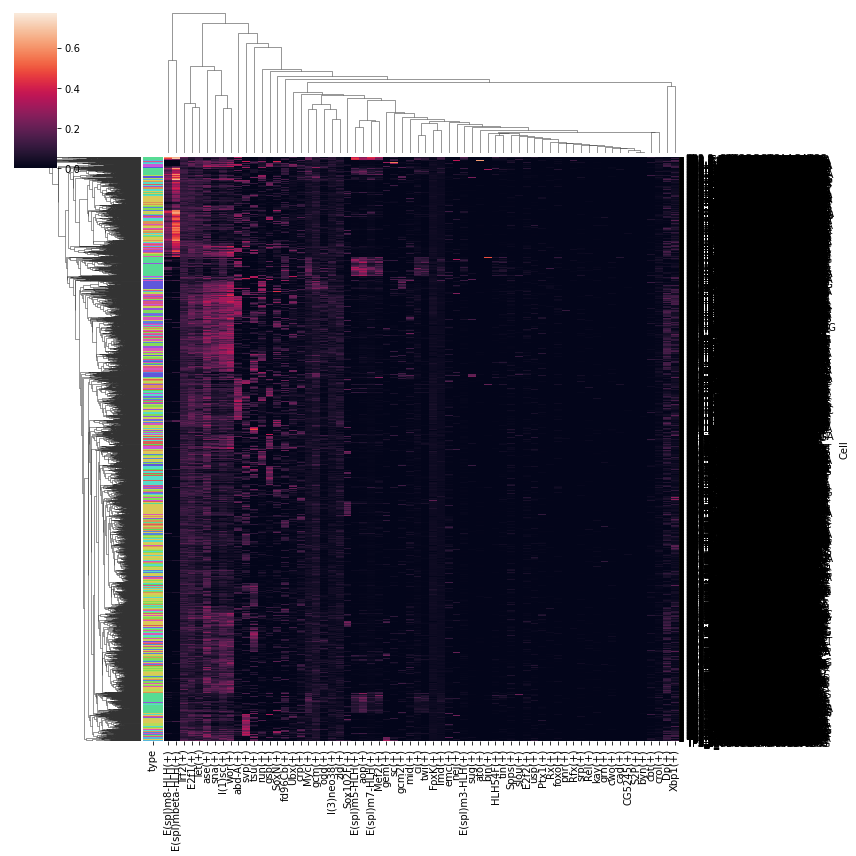

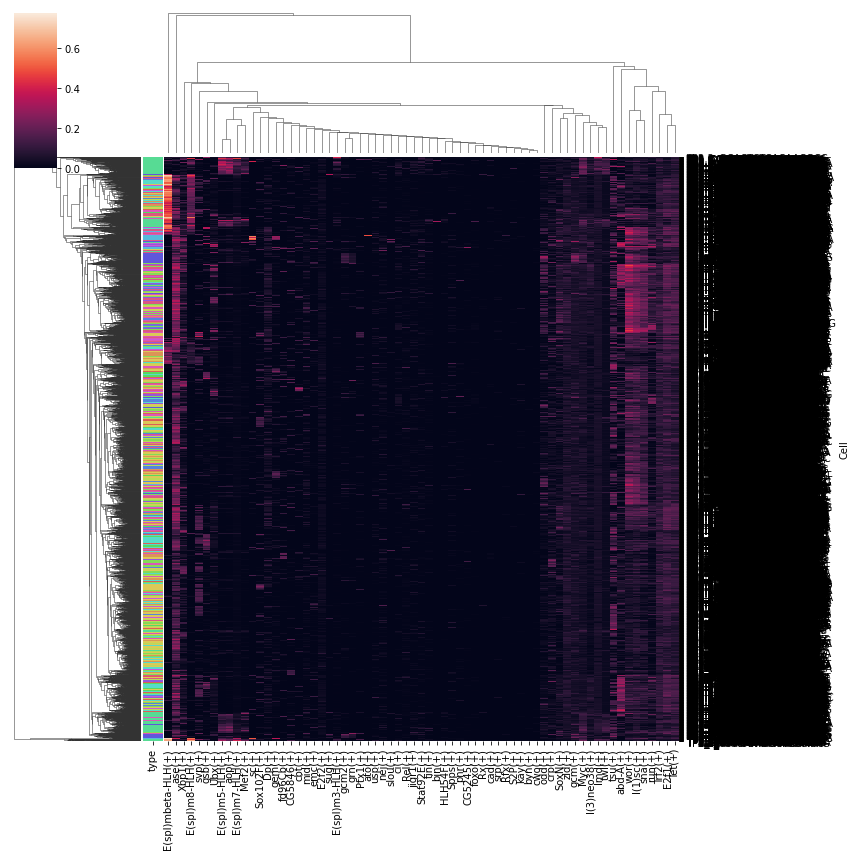

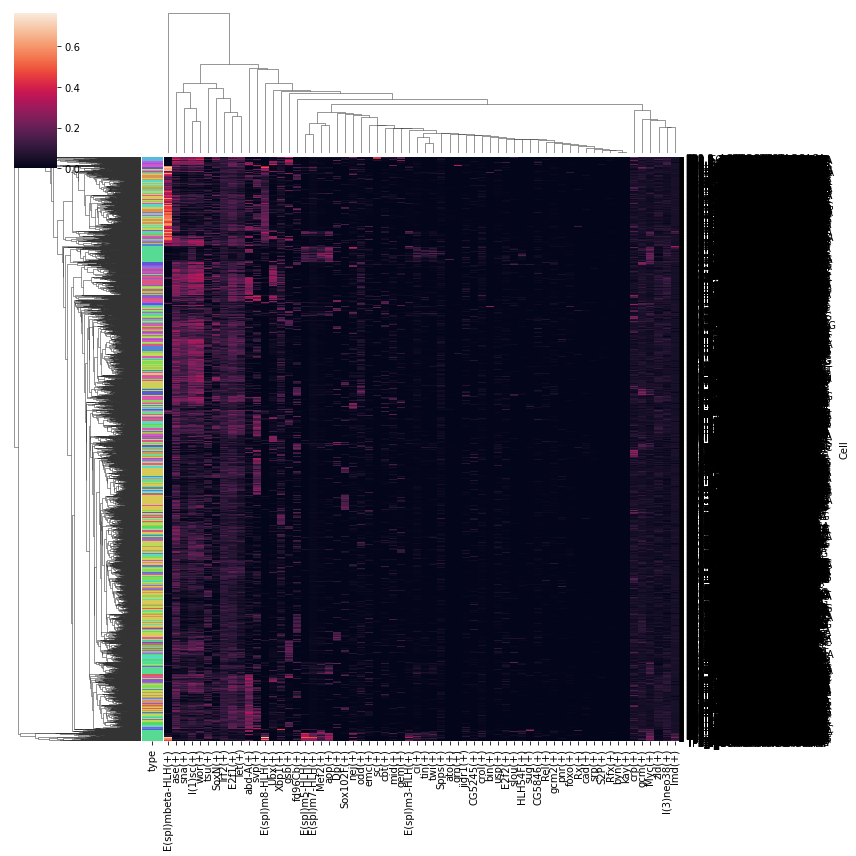

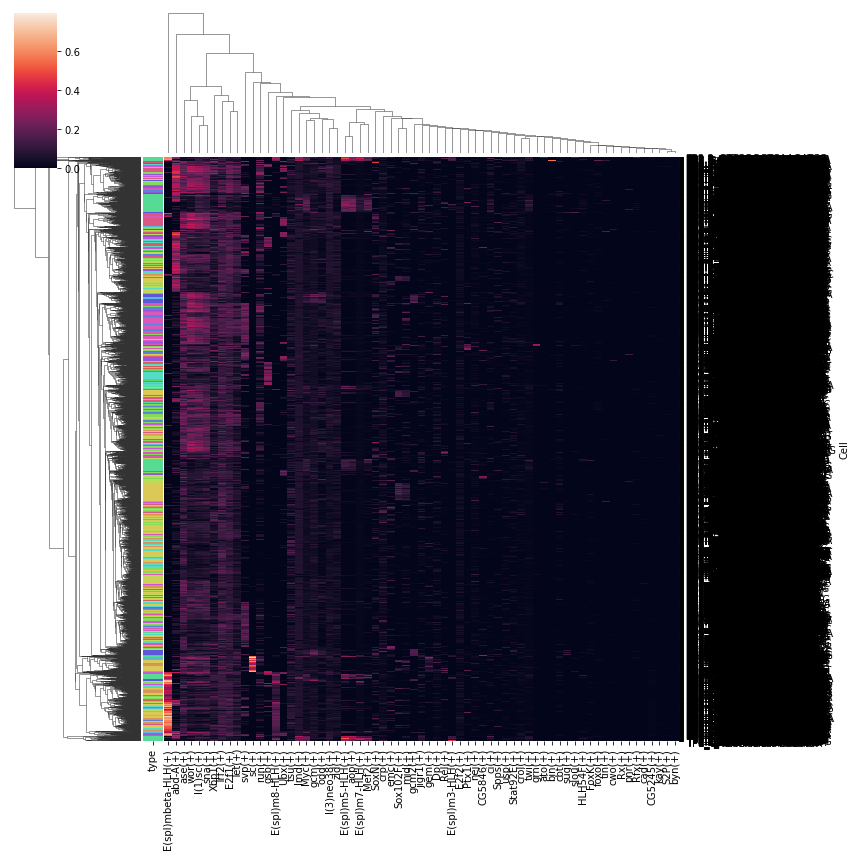

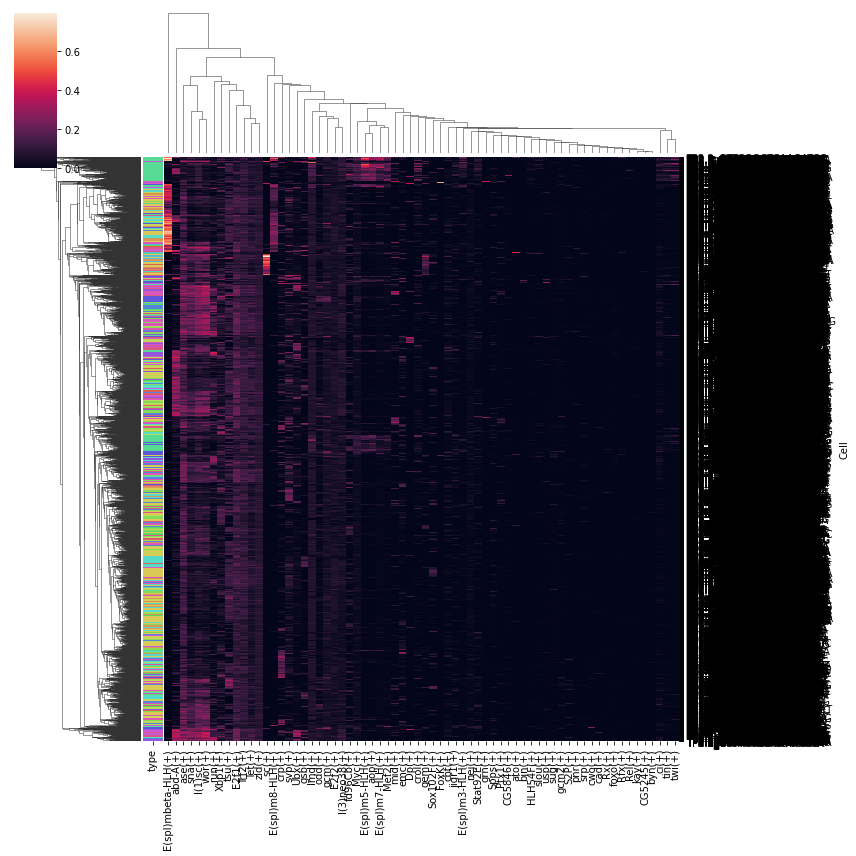

In [63]:
lut = dict(zip(types_df.type.unique(), sns.color_palette("hls", len(types_df.type.unique()))))
cell_colors = types_df.type.map(lut)

for folder in glob("../results/*/"):
    auc_mtx = pd.read_csv(folder + "AUCell_mat.csv", index_col=0)
    reg_top80 = pd.read_csv(folder + "regulons_top80.csv", index_col=0)
    # keep AUC_mtx TFs that are in reg_top80:

    auc_mtx = auc_mtx.loc[:, [col for col in auc_mtx if col.strip("(+)") in reg_top80.index.values.tolist()]]
    row_colors = auc_mtx.merge(cell_colors, how='left', left_index=True, right_index=True).type
    
    ax= sns.clustermap(auc_mtx, figsize=(12,12),yticklabels=True, xticklabels=True, row_colors=row_colors)
    ax.savefig(folder + "top80_heatmap.png")

### Heatmaps of binarization


In [64]:
import matplotlib.pyplot as plt

def plot_binarization(auc_mtx: pd.DataFrame, regulon_name: str, threshold: float, ax=None) -> None:
    """
    Plot the "binarization" process for the given regulon.

    :param auc_mtx: The dataframe with the AUC values for all cells and regulons (n_cells x n_regulons).
    :param regulon_name: The name of the regulon.
    :param bins: The number of bins to use in the AUC histogram.
    :param threshold: The threshold to use for binarization.
    """
    if ax is None:
        ax=plt.gca()
   
    auc_mtx[regulon_name].hist(ax=ax, bins='auto')  # originally bins are chosen to be 200

    ylim = ax.get_ylim()
    ax.plot([threshold]*2, ylim, 'r:')
    ax.set_ylim(ylim)
    ax.set_xlabel('AUC')
    ax.set_ylabel('# cells')
    ax.set_title(regulon_name)


In [65]:
from pyscenic.binarization import binarize

In [78]:
auc_mtx = pd.read_csv("../results/run_01/AUCell_mat.csv", index_col=0)
reg_top80 = pd.read_csv("../results/run_01/regulons_top80.csv", index_col=0)

auc_mtx = auc_mtx.loc[:, [col for col in auc_mtx if col.strip("(+)") in reg_top80.index.values.tolist()]]

binary_aucell = binarize(auc_mtx)
binary_aucell[1]

CG5846(+)          0.023328
Dp(+)              0.044786
E(spl)m3-HLH(+)    0.032595
E(spl)m5-HLH(+)    0.109799
E(spl)m7-HLH(+)    0.097376
                     ...   
tin(+)             0.029561
tsu(+)             0.112670
usp(+)             0.017343
wor(+)             0.294670
zld(+)             0.101722
Length: 64, dtype: float64

/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


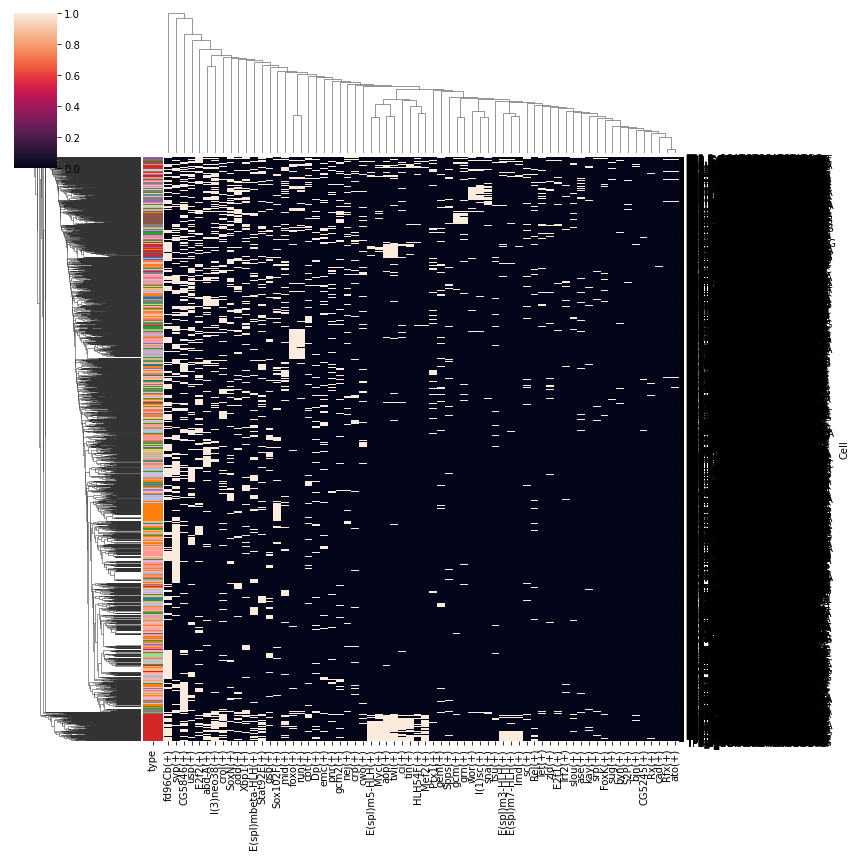

In [99]:
lut = dict(zip(types_df.type.unique(), sns.color_palette("tab20", len(types_df.type.unique()))))
cell_colors = types_df.type.map(lut)

for folder in glob("../results/*/"):
    auc_mtx = pd.read_csv(folder + "AUCell_mat.csv", index_col=0)
    reg_top80 = pd.read_csv(folder + "regulons_top80.csv", index_col=0)
    # keep AUC_mtx TFs that are in reg_top80:

    auc_mtx = auc_mtx.loc[:, [col for col in auc_mtx if col.strip("(+)") in reg_top80.index.values.tolist()]]

    binary = binarize(auc_mtx)
    binary_aucell = binary[0]  # because binarize returns a touple of (df, Series of thresholds)
    row_colors = binary_aucell.merge(cell_colors, how='left', left_index=True, right_index=True).type
    sns.clustermap(binary_aucell, figsize=(12,12),yticklabels=True, xticklabels=True, row_colors=row_colors)
    # ax.savefig(folder + "top80_binary_heatmap.png")
    
    break

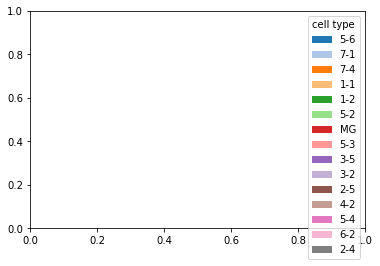

In [100]:
from matplotlib.patches import Patch

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title="cell type")

### AUCEll heatmaps of only top regulons (in >80% of runs)

In [ ]:
lut = dict(zip(types_df.type.unique(), sns.color_palette("hls", len(types_df.type.unique()))))
cell_colors = types_df.type.map(lut)

auc_mtx = pd.read_csv("../results/run_01/top80_heatmap.png", index_col=0)

for folder in glob("../results/*/"):
    auc_mtx = pd.read_csv(folder + "AUCell_mat.csv", index_col=0)
    reg_top80 = pd.read_csv(folder + "regulons_top80.csv", index_col=0)
    # keep AUC_mtx TFs that are in reg_top80:

    auc_mtx = auc_mtx.loc[:, [col for col in auc_mtx if col.strip("(+)") in reg_top80.index.values.tolist()]]
    row_colors = auc_mtx.merge(cell_colors, how='left', left_index=True, right_index=True).type
    
    ax= sns.clustermap(auc_mtx, figsize=(12,12),yticklabels=True, xticklabels=True, row_colors=row_colors)
    ax.savefig(folder + "top80_heatmap.png")

### AUCell heatmaps for top 80% TFs - grouped by cell types
Cell type specific regulon activities 

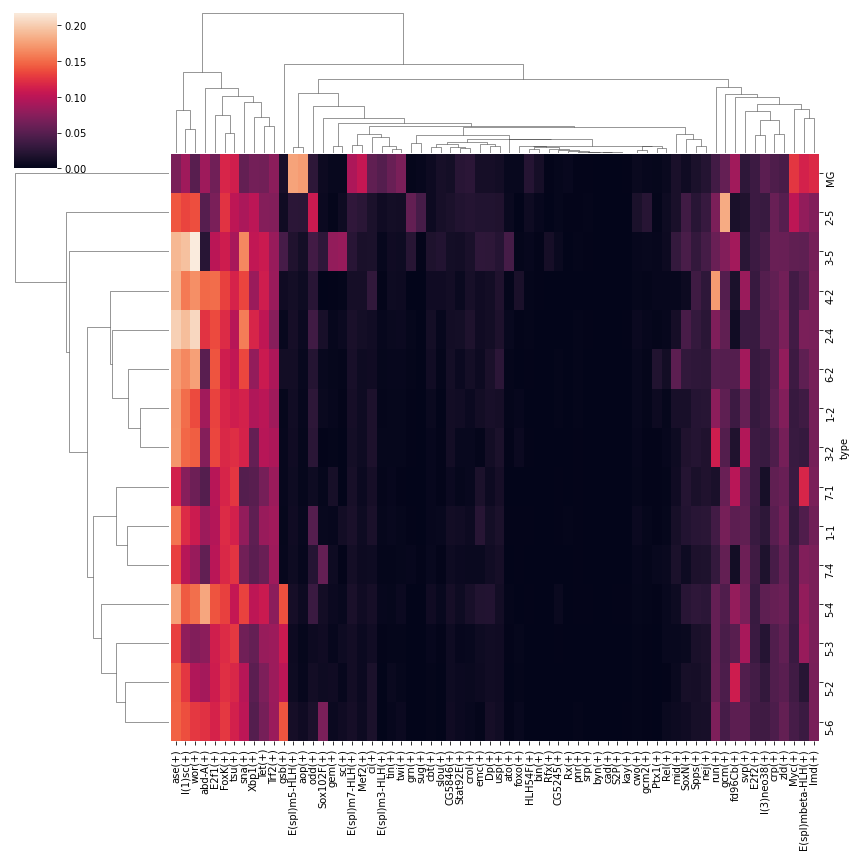

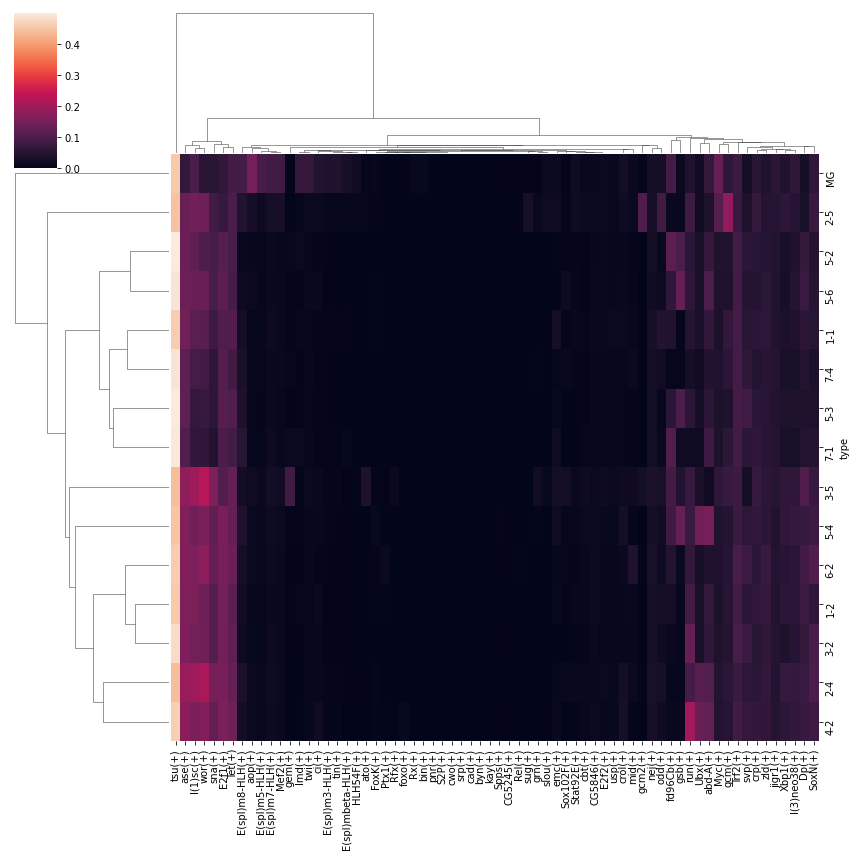

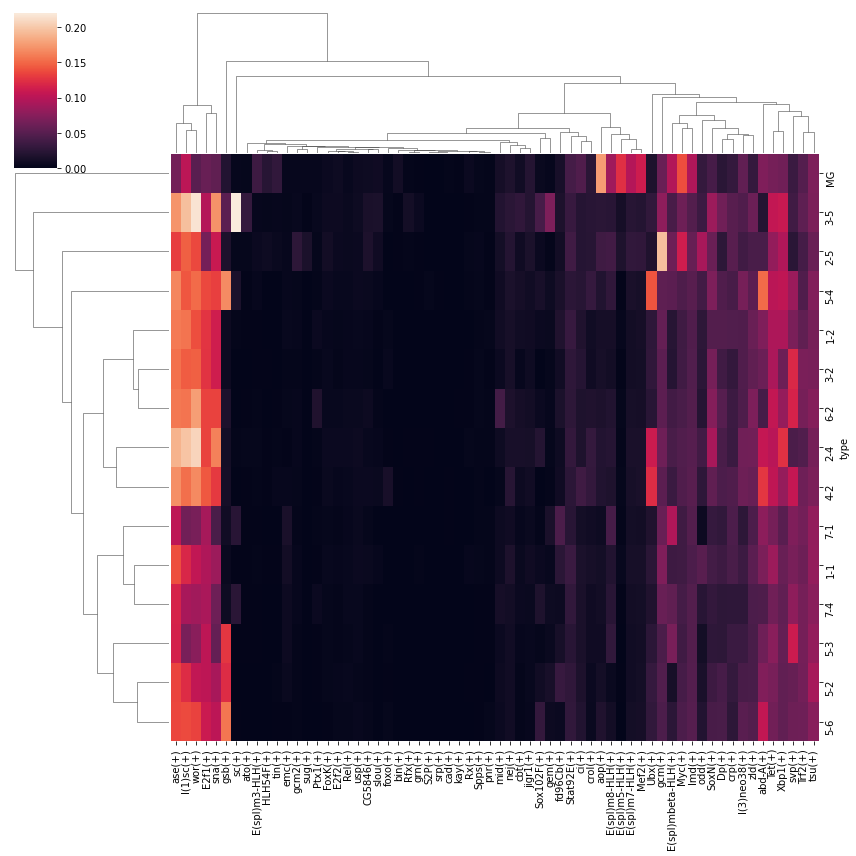

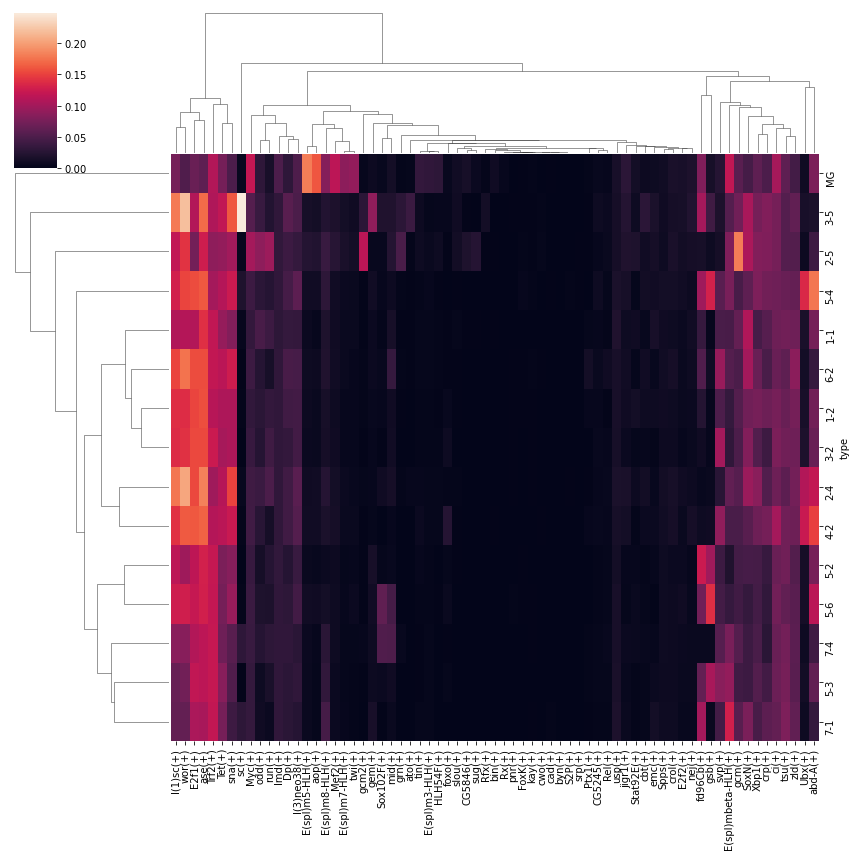

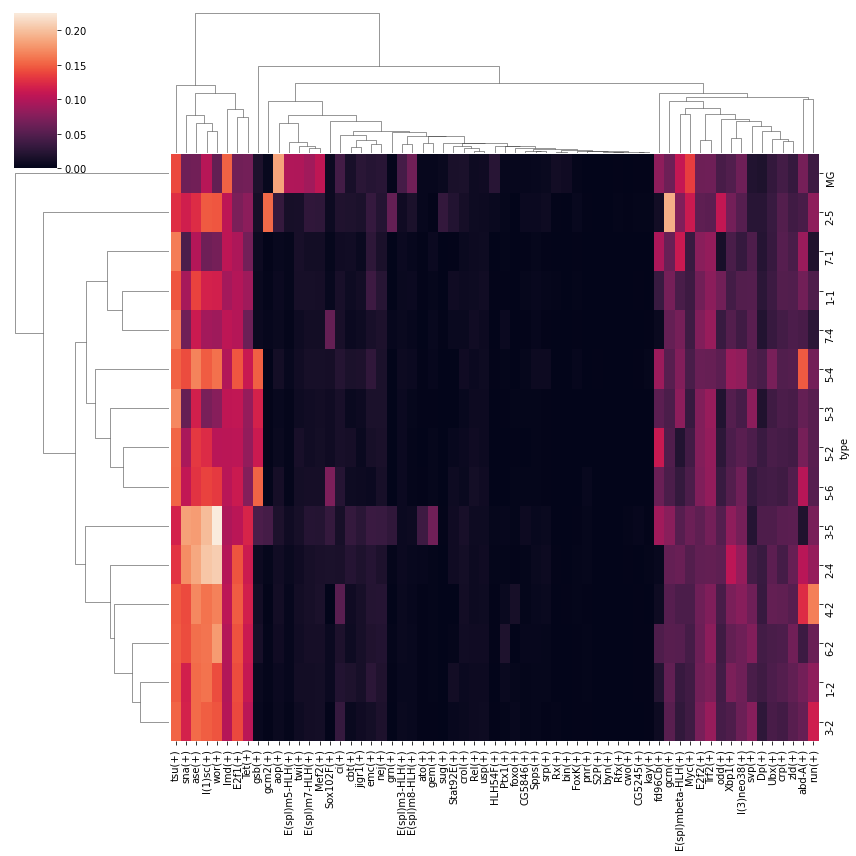

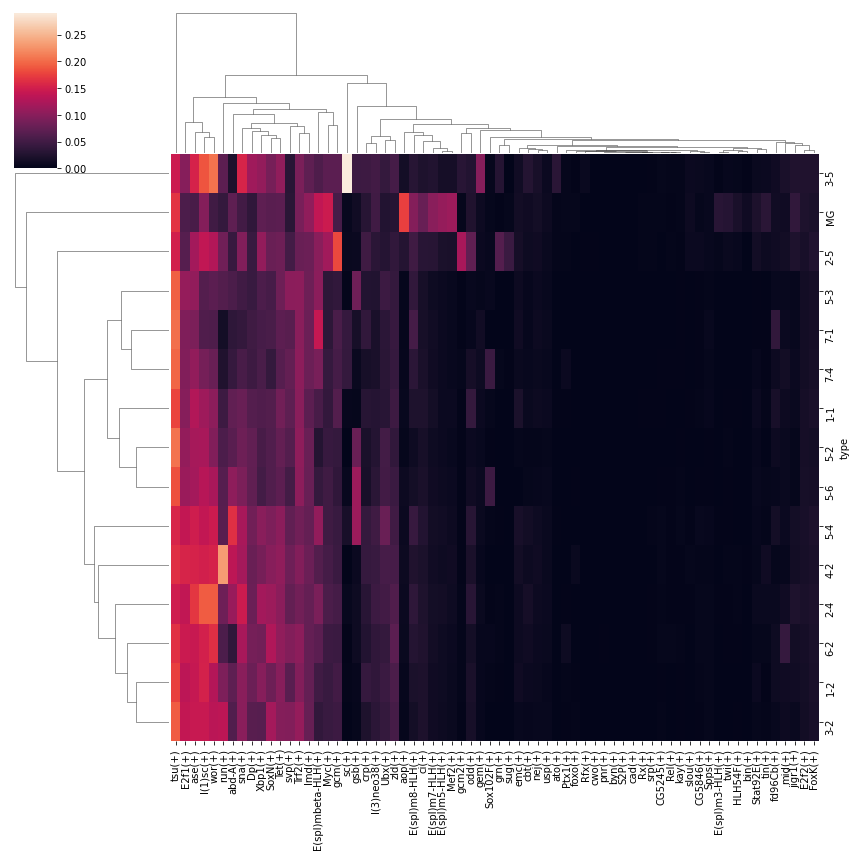

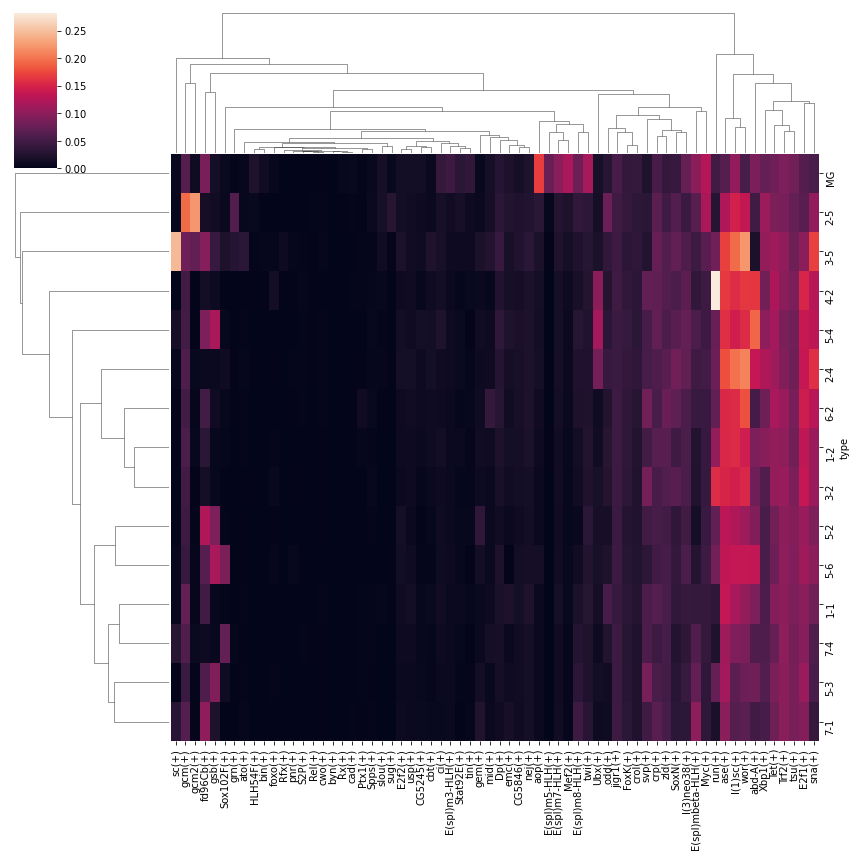

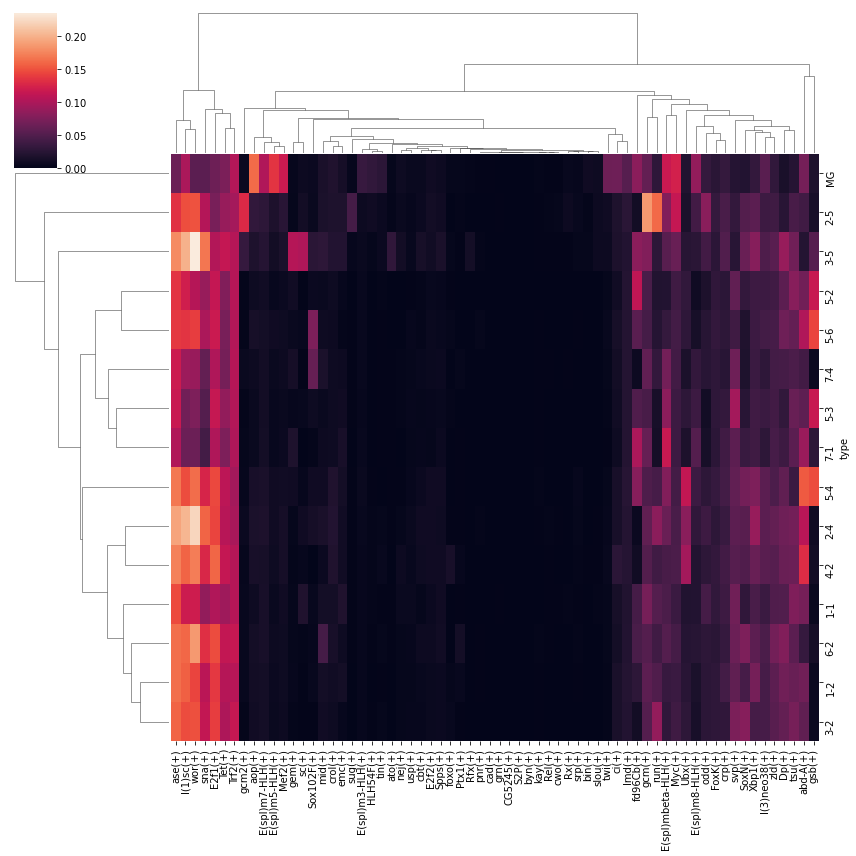

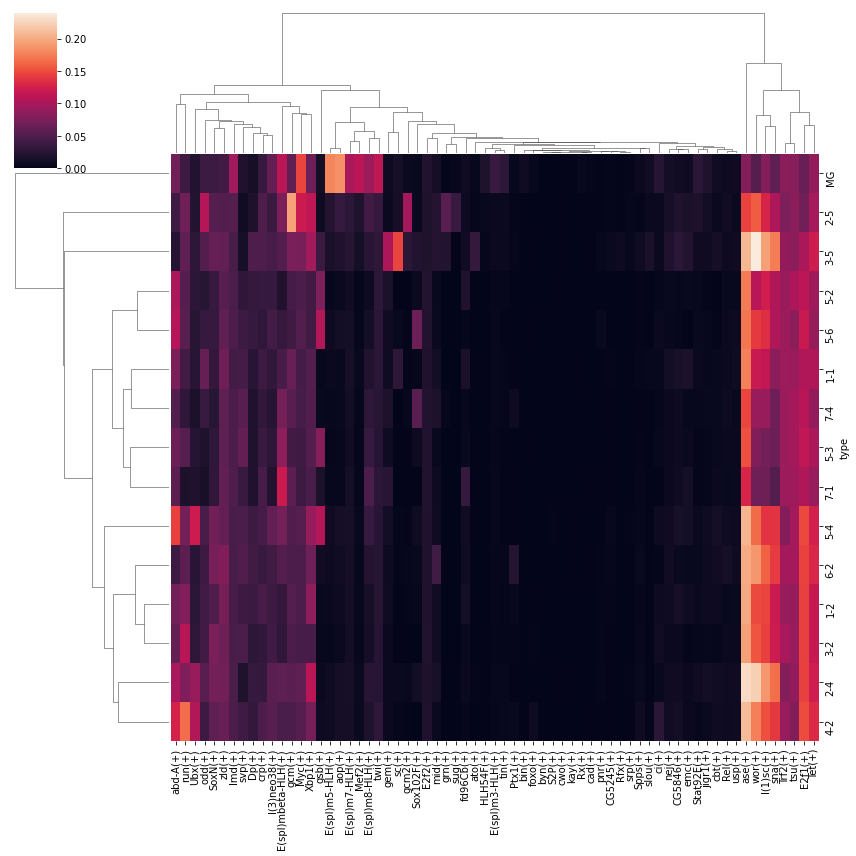

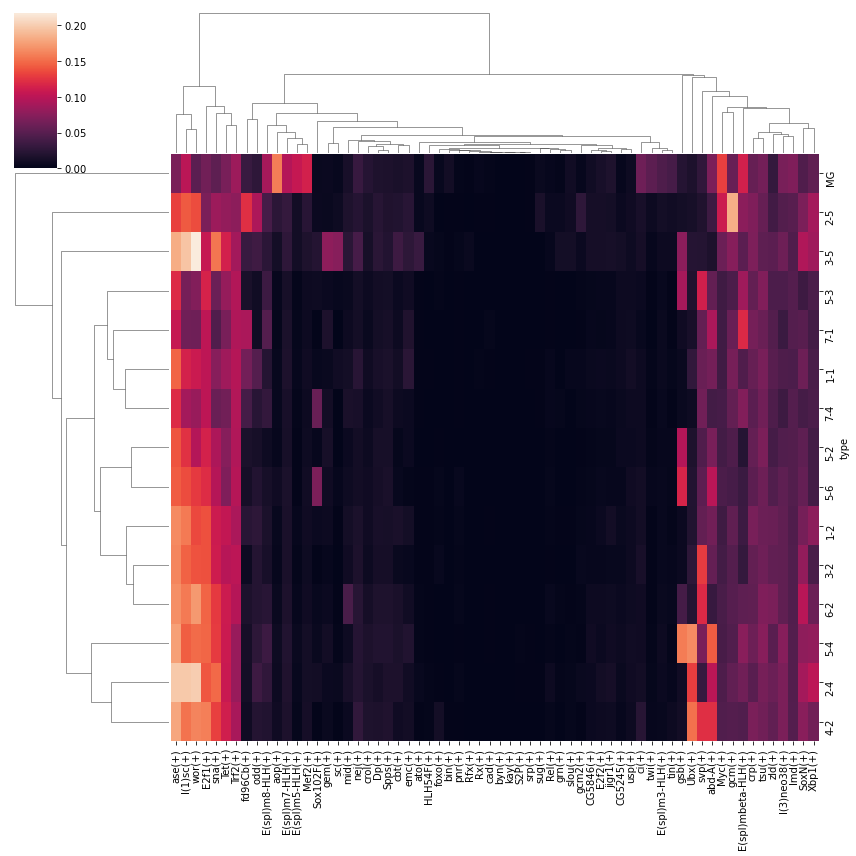

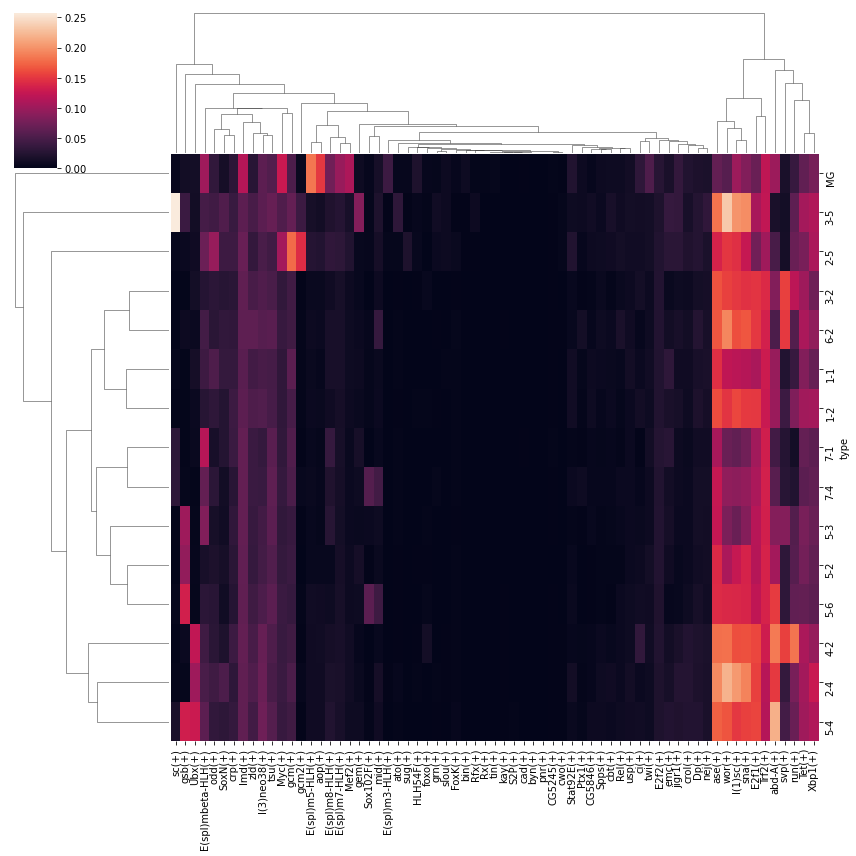

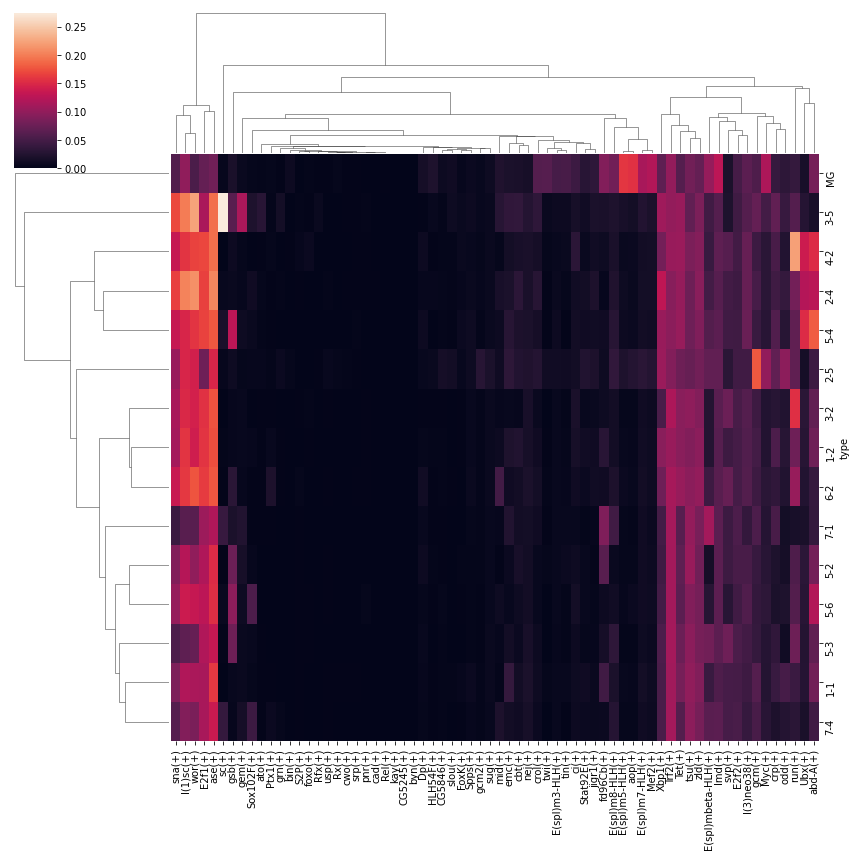

In [107]:
lut = dict(zip(types_df.type.unique(), sns.color_palette("tab20", len(types_df.type.unique()))))
cell_colors = types_df.type.map(lut)

# auc_mtx = pd.read_csv("../results/run_01/top80_heatmap.png", index_col=0)
# types df : cell (index) | type
for folder in glob("../results/*/"):
    auc_mtx = pd.read_csv(folder + "AUCell_mat.csv", index_col=0)
    reg_top80 = pd.read_csv(folder + "regulons_top80.csv", index_col=0)
    # keep AUC_mtx TFs that are in reg_top80:

    auc_mtx = auc_mtx.loc[:, [col for col in auc_mtx if col.strip("(+)") in reg_top80.index.values.tolist()]]
    auc_type = auc_mtx.merge(types_df, how='left', left_index=True, right_index=True)
    
    auc_type = auc_type.groupby("type").mean()
    
    sns.clustermap(auc_type, figsize=(12,12),yticklabels=True, xticklabels=True)
    ax.savefig(folder + "top80_heatmap_type.png")
    

## Networkx visualization of GRNs derived from pySCENIC pipeline

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

create graph

In [15]:
# get gene counts higher/equal than 8
gene_counts_8 = gene_counts.loc[gene_counts['count'].ge(9)]

In [108]:
gene_counts_8

TF      gene  count
6     CG5245   CG34382     10
74    CG5846    CG9967     10
105   CG5846      caup     10
110   CG5846  nerfin-1      9
130       Dp   CG34401     10
...      ...       ...    ...
7006     zld       nmo     11
7009     zld       nvy      9
7028     zld      simj     12
7035     zld       stg     11
7047     zld       zld     12

[1381 rows x 3 columns]

In [18]:
gene_counts_8.to_csv("../results/gene_counts_top80.csv")

add types table for Cytoscape:

gene_counts_80_type = gene_coun

In [138]:
# gene_counts_8_type = pd.DataFrame()
# gene_counts_8_type['gene'] = gene_counts_8.gene.append(gene_counts_8.TF).unique()
# gene_counts_8_type['type'] = gene_counts_8_type.gene.apply(lambda x: 'TF' if x in list(gene_counts_8.TF) else 'gene')
# gene_counts_8_type.to_csv("../results/genes_type.csv")

gene_counts_80_TFs = pd.DataFrame(gene_counts_8.TF.unique())
gene_counts_80_TFs.to_csv("../results/tf_top80.csv", index=False)


In [16]:
G = nx.from_pandas_edgelist(gene_counts_8[["TF", "gene"]], source='TF', target='gene')

draw graph

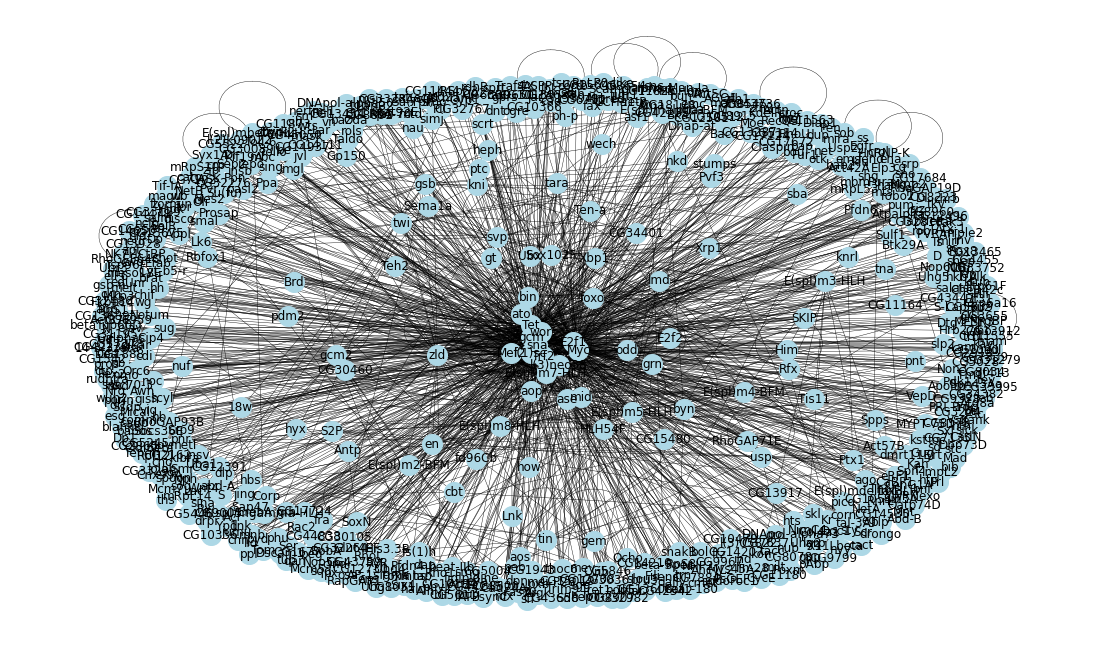

In [17]:
plt.figure(figsize=(15,9))
pos = nx.spring_layout(G, k=0.8)
nx.draw(G, pos , with_labels = True, width=0.4, 
        node_color='lightblue', node_size=400)